In [1]:
%matplotlib inline

import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import h5py

from sklearn.feature_extraction.image import extract_patches_2d

PATCH_HEIGHT = 28
PATCH_WIDTH = 28
PATCH_SHAPE = [-1, PATCH_HEIGHT, PATCH_WIDTH, 1]
PATCH_SIZE = [1, PATCH_HEIGHT, PATCH_WIDTH, 1]
PATCH_STRIDES = [1, 1, 1, 1]
PATCH_RATES = [1, 1, 1, 1]
PATCH_PADDING = 'SAME'
SEED = 1

TRAIN_PATIENTS = [
    'STS_002',
    'STS_005',
    'STS_021',
    'STS_023',
    'STS_031',
]
TEST_PATIENTS = [
    'STS_003',
    'STS_012',
]

patients = {
    'train': TRAIN_PATIENTS,
    'test': TEST_PATIENTS,
}

POSITIVE_SLICES = {
    'STS_002': (53, 63),
    'STS_003': (9, 24),
    'STS_005': (90, 123),
    'STS_012': (11, 39),
    'STS_021': (150, 189),
    'STS_023': (121, 172),
    'STS_031': (11, 41),
}

np.random.seed(SEED)
data_dir = 'data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [2]:
data = h5py.File('lab_petct_vox_5.00mm.h5', 'r')
ct_data = data['ct_data']
pet_data = data['pet_data']
y_data = data['label_data']
patient_ids = list(ct_data.keys())

In [3]:
def get_slices(data, patient_ids=patient_ids, use_pos_window=False):
    voxels = []
    for patient_id in patient_ids:
        voxel = data[patient_id].value
        
        if use_pos_window:
            window = POSITIVE_SLICES[patient_id]
            voxel = voxel[window[0]:window[1]]
        
        voxels += tf.split(tf.expand_dims(voxel, axis=3), voxel.shape[0])
    slices = tf.squeeze(tf.to_float(tf.stack(voxels)), [1])
    with tf.Session() as sess:
        return sess.run(slices)

def normalize(slices):
    with tf.Session() as sess:
        return sess.run(
            tf.map_fn(
                lambda img: tf.image.per_image_standardization(img), slices))

def get_img_patches(ct_slices, pet_slices, split=False, y_slices=None, print_every=10):
    if split:
        num_slices = ct_slices.shape[0]
        
        ct_pos = []
        ct_neg = []
        pet_pos = []
        pet_neg = []
        y_pos = []
        y_neg = []
        
        for i in range(num_slices):
            ct_slice = np.expand_dims(ct_slices[i], axis=0)
            pet_slice = np.expand_dims(pet_slices[i], axis=0)
            y_slice = np.expand_dims(y_slices[i], axis=0)
            
            pos_mask, y_patches = get_positives(y_slice)
            neg_mask = get_negatives(pos_mask)
            
            ct_patches = tf.extract_image_patches(
                ct_slice, PATCH_SIZE, PATCH_STRIDES, PATCH_RATES, PATCH_PADDING)
            pet_patches = tf.extract_image_patches(
                pet_slice, PATCH_SIZE, PATCH_STRIDES, PATCH_RATES, PATCH_PADDING)
            
            ct_square_patches = tf.reshape(ct_patches, PATCH_SHAPE)
            pet_square_patches = tf.reshape(pet_patches, PATCH_SHAPE)
            
            with tf.Session() as sess:
                ct_patches = sess.run(ct_square_patches)
                pet_patches = sess.run(pet_square_patches)
            
            ct_pos_square_patches = ct_patches[pos_mask]
            ct_neg_square_patches = ct_patches[neg_mask]
            pet_pos_square_patches = pet_patches[pos_mask]
            pet_neg_square_patches = pet_patches[neg_mask]
            y_pos_square_patches = y_patches[pos_mask]
            y_neg_square_patches = y_patches[neg_mask]
            
            ct_pos.append(ct_pos_square_patches)
            ct_neg.append(ct_neg_square_patches)
            pet_pos.append(pet_pos_square_patches)
            pet_neg.append(pet_neg_square_patches)
            y_pos.append(y_pos_square_patches)
            y_neg.append(y_neg_square_patches)
            
            if (i + 1) % print_every == 0:
                print(f'{i + 1}/{num_slices} slices processed')
        
        ct_pos = np.vstack(ct_pos)
        ct_neg = np.vstack(ct_neg)
        pet_pos = np.vstack(pet_pos)
        pet_neg = np.vstack(pet_neg)
        y_pos = np.vstack(y_pos)
        y_neg = np.vstack(y_neg)
        return (ct_pos, ct_neg), (pet_pos, pet_neg), (y_pos, y_neg)
    else:
        num_slices = ct_slices.shape[0]
        
        ct = []
        pet = []
        
        for i in range(num_slices):
            ct_slice = np.expand_dims(ct_slices[i], axis=0)
            pet_slice = np.expand_dims(pet_slices[i], axis=0)
            
            ct_patches = tf.extract_image_patches(
                ct_slice, PATCH_SIZE, PATCH_STRIDES, PATCH_RATES, PATCH_PADDING)
            pet_patches = tf.extract_image_patches(
                pet_slice, PATCH_SIZE, PATCH_STRIDES, PATCH_RATES, PATCH_PADDING)
            
            ct_square_patches = tf.reshape(ct_patches, PATCH_SHAPE)
            pet_square_patches = tf.reshape(pet_patches, PATCH_SHAPE)
            
            with tf.Session() as sess:
                ct_patches = sess.run(ct_square_patches)
                pet_patches = sess.run(pet_square_patches)
            
            ct.append(ct_patches)
            pet.append(pet_patches)
            
            if (i + 1) % print_every == 0:
                print(f'{i + 1} slices processed')
        
        ct = np.vstack(ct)
        pet = np.vstack(pet)
        return ct, pet
    
def get_patch_labels(y_slices):
    patches = tf.extract_image_patches(
        y_slices, PATCH_SIZE, PATCH_STRIDES, PATCH_RATES, PATCH_PADDING)
    square_patches = tf.reshape(patches, PATCH_SHAPE)
    center_pixels = square_patches[:, PATCH_HEIGHT // 2, PATCH_WIDTH // 2, :]
    indices = tf.squeeze(tf.to_int32(tf.greater(center_pixels, 0)))
    y = tf.one_hot(indices, 2)
    with tf.Session() as sess:
        return sess.run([y, square_patches])

def get_positives(y_slices):
    y, y_patches = get_patch_labels(y_slices)
    pos_mask = (y[:, 1] == 1.).flatten()
    return pos_mask, y_patches

def get_negatives(pos_mask):
    neg_indices = np.where(pos_mask == False)[0]
    num_pos = np.sum(pos_mask)
    neg_indices = np.random.choice(neg_indices, num_pos, replace=False)
    neg_mask = np.ma.make_mask(np.zeros(pos_mask.shape[0]), shrink=False)
    neg_mask[neg_indices] = True
    return neg_mask

def gen_patches(dataset='train'):
    patient_ids = patients[dataset]
    ct_slices = normalize(get_slices(ct_data, use_pos_window=True, patient_ids=patient_ids))
    pet_slices = normalize(get_slices(pet_data, use_pos_window=True, patient_ids=patient_ids))
    y_slices = get_slices(y_data, use_pos_window=True, patient_ids=patient_ids)
    
    ct, pet, y = get_img_patches(
        ct_slices, pet_slices, split=True, y_slices=y_slices)
    ct_pos, ct_neg = ct
    pet_pos, pet_neg = pet
    y_pos, y_neg = y
    
    np.save(os.path.join(data_dir, f'ct_{dataset}_pos.npy'), ct_pos)
    np.save(os.path.join(data_dir, f'ct_{dataset}_neg.npy'), ct_neg)
    np.save(os.path.join(data_dir, f'pet_{dataset}_pos.npy'), pet_pos)
    np.save(os.path.join(data_dir, f'pet_{dataset}_neg.npy'), pet_neg)
    np.save(os.path.join(data_dir, f'y_{dataset}_pos.npy'), y_pos)
    np.save(os.path.join(data_dir, f'y_{dataset}_neg.npy'), y_neg)
    
def merge_patches(dataset='train'):
    ct_pos = np.load(os.path.join(data_dir, f'ct_{dataset}_pos.npy'))
    ct_neg = np.load(os.path.join(data_dir, f'ct_{dataset}_neg.npy'))
    pet_pos = np.load(os.path.join(data_dir, f'pet_{dataset}_pos.npy'))
    pet_neg = np.load(os.path.join(data_dir, f'pet_{dataset}_neg.npy'))
    y_pos_patches = np.load(os.path.join(data_dir, f'y_{dataset}_pos.npy'))
    y_neg_patches = np.load(os.path.join(data_dir, f'y_{dataset}_neg.npy'))
    y_pos = np.repeat([[0., 1.]], ct_pos.shape[0], axis=0)
    y_neg = np.repeat([[1., 0.]], ct_neg.shape[0], axis=0)
    
    ct = np.vstack([ct_pos, ct_neg])
    pet = np.vstack([pet_pos, pet_neg])
    y_patches = np.vstack([y_pos_patches, y_neg_patches])
    y = np.vstack([y_pos, y_neg])
    
    with tf.Session() as sess:
        ct = sess.run(tf.random_shuffle(ct, seed=SEED))
        pet = sess.run(tf.random_shuffle(pet, seed=SEED))
        y_patches = sess.run(tf.random_shuffle(y_patches, seed=SEED))
        y = sess.run(tf.random_shuffle(y, seed=SEED))
    
    np.save(os.path.join(data_dir, f'ct_{dataset}.npy'), ct)
    np.save(os.path.join(data_dir, f'pet_{dataset}.npy'), pet)
    np.save(os.path.join(data_dir, f'y_patches_{dataset}.npy'), y_patches)
    np.save(os.path.join(data_dir, f'y_{dataset}.npy'), y)
    

In [16]:
gen_patches('train')
merge_patches('train')

10/163 slices processed
20/163 slices processed
30/163 slices processed
40/163 slices processed
50/163 slices processed
60/163 slices processed
70/163 slices processed
80/163 slices processed
90/163 slices processed
100/163 slices processed
110/163 slices processed
120/163 slices processed
130/163 slices processed
140/163 slices processed
150/163 slices processed
160/163 slices processed


In [17]:
gen_patches('test')
merge_patches('test')

10/43 slices processed
20/43 slices processed
30/43 slices processed
40/43 slices processed


In [6]:
def get_mismatches(data='train', clazz='pos', threshold=0.5):
    ct = np.load(os.path.join(data_dir, f'ct_{data}_{clazz}.npy'))
    pet = np.load(os.path.join(data_dir, f'pet_{data}_{clazz}.npy'))
    y_patches = np.load(os.path.join(data_dir, f'y_{data}_{clazz}.npy'))

    mean_labels = tf.squeeze(tf.to_int32(tf.greater(tf.reduce_mean(y_patches, axis=[1, 2, 3]), threshold)))
    not_equal = tf.not_equal(mean_labels, int(clazz == 'pos'))
    indices = tf.reshape(tf.where(not_equal), [-1])

    bad_ct = tf.gather(ct, indices)
    bad_pet = tf.gather(pet, indices)
    bad_y = tf.gather(y_patches, indices)

    with tf.Session() as sess:
        bad_ct, bad_pet, bad_y = sess.run([bad_ct, bad_pet, bad_y])

    bad_count = bad_ct.shape[0]
    print(f'Bads: {bad_count}/{y_patches.shape[0]}')
    return bad_ct, bad_pet, bad_y
    

In [11]:
bad_ct, bad_pet, bad_y = get_mismatches(data='train', clazz='pos', threshold=0.5)

Bads: 9395/20669


Center-Pixel Label: False
Patch Mean: 0.5114796161651611


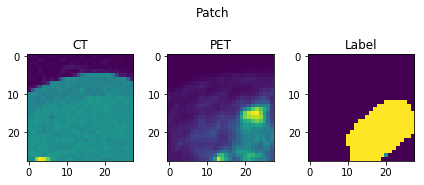

In [10]:
index = 140

y_patch = bad_y[index].reshape((PATCH_HEIGHT, PATCH_WIDTH))
center_pixel = y_patch[PATCH_HEIGHT // 2, PATCH_WIDTH // 2] > 0
pet_patch = bad_pet[index].reshape((PATCH_HEIGHT, PATCH_WIDTH))
ct_patch = bad_ct[index].reshape((PATCH_HEIGHT, PATCH_WIDTH))

print(f'Center-Pixel Label: {center_pixel}')
print(f'Patch Mean: {np.mean(y_patch)}')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Patch', y=0.85)
ax1.imshow(ct_patch)
ax1.set_title('CT')
ax2.imshow(pet_patch)
ax2.set_title('PET')
ax3.imshow(y_patch)
ax3.set_title('Label')
plt.tight_layout()

fig.savefig('patch.png', bbox_inches='tight')
plt.show()
